In [38]:
from blackbody import blackbody_radiation
from sail_simulation import Sail_Material, Sail_Model, simulate_sail_at_wavelength
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

First import the optical values for the materials that are to be used and scale them to si units

In [39]:
def format_refraction_data(df: pd.DataFrame):
    df.columns = ['wavelength', 'n', 'k']
    df = df.fillna(method='ffill') # replace NaN with zero, as this is most consistent with the datasets
    df['wavelength'] = df['wavelength'] * 1e-6
    return df

aluminum_refraction_data = format_refraction_data(pd.read_csv('./data\\RefractiveIndexAl.csv'))
chrome_refraction_data = format_refraction_data(pd.read_csv('./data\\RefractiveIndexChrome.csv'))
kapton_refraction_data = format_refraction_data(pd.read_csv('./data\\RefractiveIndexKapton.csv'))

Then make a sail as described in the nasa paper

In [40]:
front_aluminum_coating = Sail_Material('Front Aluminum Layer', 50e-9, aluminum_refraction_data)
front_chrome_coating = Sail_Material('Front Chrome Layer', 50e-9, chrome_refraction_data)
structural_layer_kapton = Sail_Material('Structural Kapton Layer', 8e-6, kapton_refraction_data)
back_aluminum_coating = Sail_Material('Back Aluminum Layer', 50e-9, aluminum_refraction_data)

aluminum_sail = Sail_Model([front_aluminum_coating, structural_layer_kapton, back_aluminum_coating])
chrome_sail = Sail_Model([front_chrome_coating, structural_layer_kapton, back_aluminum_coating])

c:\Users\sidne\source\repos\sidney-pauly\papers\uoa-px2013-essay\src\python\blackbody.py:13: RuntimeWarning: overflow encountered in scalar power
  exponential = 1/(math.e**((planck_constant*speed_of_light)/(wavelength * boltzmann_constant * temperature)) - 1)


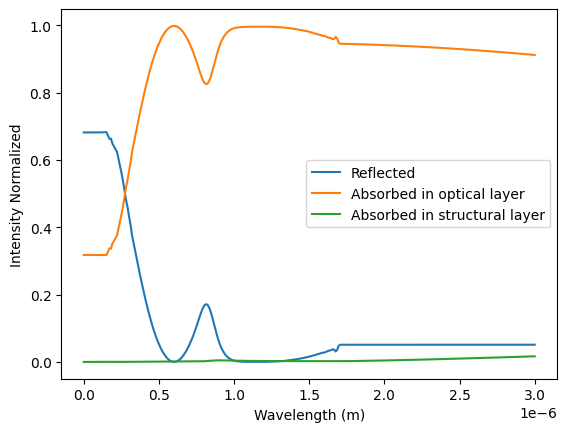

In [41]:
wavelength_to_consider = np.linspace(1e-9, 3000e-9, 300)

blackbody = [blackbody_radiation(w, 5778) for w in wavelength_to_consider]
integrated = np.trapz(blackbody)
blackbody = blackbody / integrated

def calculate_sail_properties(sail, angle_degrees):

    c = 299792458
    angle = angle_degrees/180*math.pi

    result_by_wavelength = [simulate_sail_at_wavelength(sail, angle, wavelength) for wavelength in wavelength_to_consider]
    reflected = [w[0] for w in result_by_wavelength]
    absorbed_1  = [w[2][0] for w in result_by_wavelength]
    absorbed_2  = [w[2][1] for w in result_by_wavelength]
    absorbed_3  = [w[2][1] for w in result_by_wavelength]
    
    reflected_weighted = blackbody * reflected
    absorbed_1_weighted = blackbody * absorbed_1
    absorbed_2_weighted = blackbody * absorbed_2
    absorbed_3_weighted = blackbody * absorbed_3

    total_absorbed = np.trapz(absorbed_1_weighted) + np.trapz(absorbed_2_weighted) + np.trapz(absorbed_3_weighted)
    total_reflected = 2 * np.trapz(reflected_weighted)

    optical_efficiency = math.sqrt((math.cos(angle) * (total_reflected + total_absorbed)/c)**2 + (math.sin(angle)*total_absorbed/c)**2)/(2/c)
    total_efficiency = optical_efficiency * math.cos(angle)

    return {
        'reflected': reflected,
        'reflected_weighted': reflected_weighted,
        'absorbed_1': absorbed_1,
        'absorbed_2': absorbed_2,
        'absorbed_3': absorbed_3,
        'absorbed_1_weighted': absorbed_1_weighted,
        'absorbed_2_weighted': absorbed_2_weighted,
        'absorbed_3_weighted': absorbed_3_weighted,
        'optical_efficiency': optical_efficiency,
        'total_efficiency': total_efficiency, 
    }

    
aluminum_sail_result = calculate_sail_properties(aluminum_sail, 0)

plt.figure()
plt.plot(wavelength_to_consider, aluminum_sail_result['reflected'], label='Reflected')
plt.plot(wavelength_to_consider, aluminum_sail_result['absorbed_1'], label='Absorbed in optical layer')
plt.plot(wavelength_to_consider, aluminum_sail_result['absorbed_2'], label='Absorbed in structural layer')

plt.legend()
plt.xlabel('Wavelength (m)')
plt.ylabel('Intensity Normalized')

plt.savefig('./output/reflection_and_absorption_aluminum_sail.png')

plt.show()



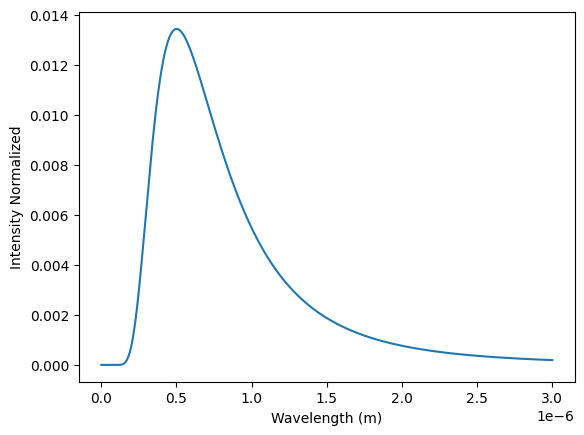

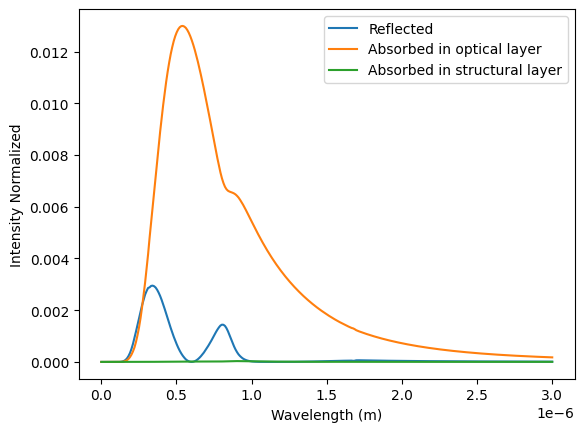

In [42]:

plt.figure()
plt.plot(wavelength_to_consider, blackbody)

plt.xlabel('Wavelength (m)')
plt.ylabel('Intensity Normalized')

plt.savefig('./output/blackbody_radiation_sun.png')


plt.figure()
plt.plot(wavelength_to_consider, aluminum_sail_result['reflected_weighted'], label='Reflected')
plt.plot(wavelength_to_consider, aluminum_sail_result['absorbed_1_weighted'], label='Absorbed in optical layer')
plt.plot(wavelength_to_consider, aluminum_sail_result['absorbed_2_weighted'], label='Absorbed in structural layer')

plt.legend()

plt.xlabel('Wavelength (m)')
plt.ylabel('Intensity Normalized')

plt.savefig('./output/reflection_and_absorption_aluminum_sail_weighted.png')

plt.show()



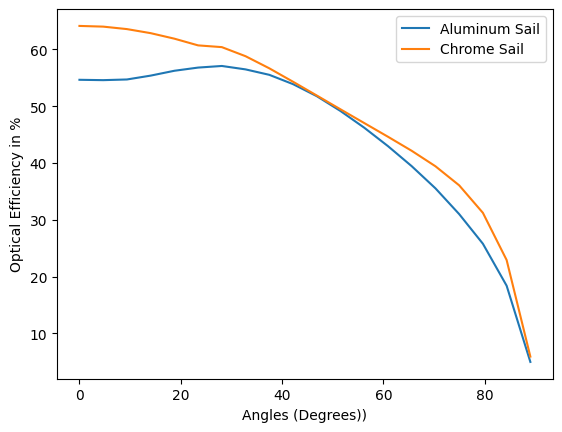

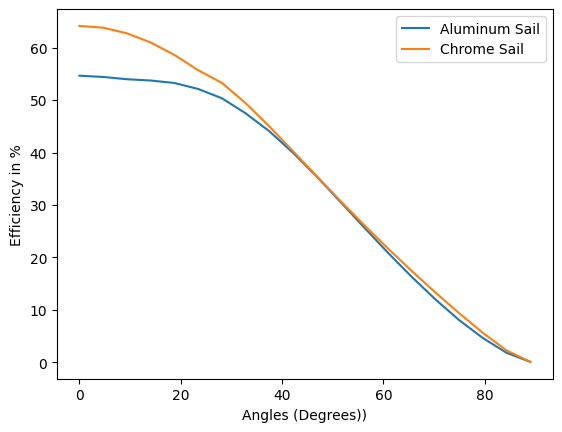

In [43]:
angles_to_consider = np.linspace(0, 89, 20)

aluminum_sail_at_angles = [calculate_sail_properties(aluminum_sail, a) for a in angles_to_consider]
chrome_sail_at_angles = [calculate_sail_properties(chrome_sail, a) for a in angles_to_consider]

aluminum_sail_optical_efficiency = np.array([p['optical_efficiency'] for p in aluminum_sail_at_angles])
aluminum_sail_actual_efficiency = np.array([p['total_efficiency'] for p in aluminum_sail_at_angles])

chrome_sail_optical_efficiency = np.array([p['optical_efficiency'] for p in chrome_sail_at_angles])
chrome_sail_actual_efficiency =  np.array([p['total_efficiency'] for p in chrome_sail_at_angles])

plt.figure()
plt.plot(angles_to_consider, aluminum_sail_optical_efficiency*100, label='Aluminum Sail')
plt.plot(angles_to_consider, chrome_sail_optical_efficiency*100, label='Chrome Sail')
plt.legend()

plt.xlabel('Angles (Degrees))')
plt.ylabel('Optical Efficiency in %')
plt.savefig('./output/optical_efficiency.png')
plt.show()

plt.figure()
plt.plot(angles_to_consider, aluminum_sail_actual_efficiency*100, label='Aluminum Sail')
plt.plot(angles_to_consider, chrome_sail_actual_efficiency*100, label='Chrome Sail')
plt.legend()

plt.xlabel('Angles (Degrees))')
plt.ylabel('Efficiency in %')
plt.savefig('./output/efficiency.png')
plt.show()


